In [2]:
from bs4 import BeautifulSoup
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import random
from dateutil.parser import parse
import re

%matplotlib inline
rainbow_colors = cm.rainbow(np.linspace(0, 1, 15))
random.seed(123)
plt.style.use('ggplot')

In [3]:
movie_data = pd.read_csv('../movie_reviews.csv')

movie_data.rename(columns={'Sci-Fi': 'SciFi', 'Reality-TV': 'RealityTV', 
                           'Talk-Show': 'TalkShow', 'Film-Noir': 'FilmNoir'}, 
                  inplace=True)

In [4]:
date_parser = lambda i: parse(i) if i is not np.nan else np.nan
movie_data.reviewer = movie_data.reviewer.astype('category')
movie_data.review_date = movie_data.review_date.apply(date_parser)
movie_data.release_date = movie_data.release_date.apply(date_parser)
movie_data.acclaim_rate = movie_data.acclaim_rate.astype('category')
movie_data.director = movie_data.director.astype('category')
movie_data.languages = movie_data.languages.astype('category')
movie_data.release_decade = movie_data.release_decade.astype('category')

# Parte 1 — The New York Times

# Parte 2 — Gêneros

In [5]:
genres = movie_data.columns[11:-2].drop('unknown')
fiveGenres = movie_data[genres].sum().nlargest(5)
fiveGenres = [i for i in fiveGenres.index.values]

meta_content = {}; review_content = {}
for genre in fiveGenres:
    meta = movie_data.groupby(genre)['metascore']
    review = movie_data.groupby(genre)['review_score']
    meta_content[genre] = meta.get_group(1).values
    review_content[genre] = review.get_group(1).values
    
fiveGenresMeta = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in meta_content.items()])).reset_index(drop=True)
fiveGenresReviews = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in review_content.items()])).reset_index(drop=True)

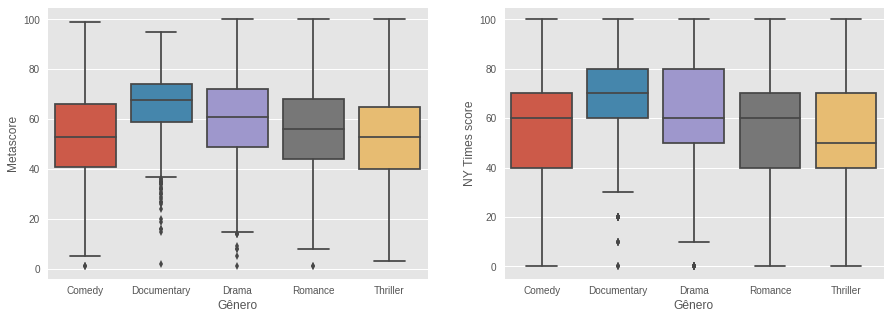

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
sns.boxplot(data=fiveGenresMeta.dropna(), ax=axes[0])
sns.boxplot(data=fiveGenresReviews.dropna(), ax=axes[1])
axes[0].set_ylabel('Metascore'); axes[1].set_ylabel('NY Times score')
for axis in axes: axis.set_xlabel('Gênero')

É possível verificar que a distribuição do Metascore se apresenta heterogênea para a maioria dos principais gêneros. Apesar disso, é possível verificar que a amplitude interquartil dos filmes de comédia e de suspense, por exemplo, se concentram mais em escores mistos, enquanto os filmes de drama estão bem distribuídos entre positivos e mistos, centrando melhor em torno do escore médio adotado pelo site (60). Em contraste, os documentários se apresentam mais homogêneos e centrados em torno de notas positivas — apesar de estes também possuírem uma quantidade maior de *outliners*.

Já entre as reviews do The New York Times, podemos ver que há um pouco mais de heterogeneidade e uma redução do número de *outliners*. Não obstante, também pode-se observar que existem gêneros, a exemplo dos filmes de drama e de romance, de igual mediana, mas com amplitudes interquartis significativamente diferentes — voltadas mais para escores positivos e mais para escores mistos, respectivamente. Similarmente, também há filmes de amplitude interquartil similar, mas com medianas diferentes.

In [7]:
model = smf.ols('metascore ~ ' + ' + '.join(fiveGenres), movie_data).fit()
result = pd.concat([model.params, model.bse, model.tvalues, model.pvalues],
                    axis=1, keys=['coef', 'SE', 't', 'p-value'])
display(result)

,coef,SE,t,p-value
Intercept,52.571061,0.388918,135.172690,0.000000e+00
Drama,8.013722,0.354225,22.623265,5.771329e-111
Comedy,-3.191328,0.377527,-8.453251,3.164997e-17
Thriller,-3.601468,0.406692,-8.855517,9.515396e-19
Documentary,13.344107,0.493822,27.022120,4.345169e-156
Romance,-0.782250,0.414500,-1.887212,5.915631e-02


In [8]:
model = smf.ols('metascore ~ Romance', movie_data).fit()
result = pd.concat([model.params, model.bse, model.tvalues, model.pvalues],
                    axis=1, keys=['coef', 'SE', 't', 'p-value'])
display(result)

,coef,SE,t,p-value
Intercept,57.898848,0.174006,332.74114,0.000000e+00
Romance,-2.445535,0.423488,-5.77474,7.901647e-09


Conforme os resultados verificados acima, é possível concluir que a categorização do filme como um documentário é habitualmente associada a um Metascore mais alto. Em contraste, filmes de suspense se encontram associados a escores mais baixos. Por fim, é possível verificar que os filmes de romance não são contemplados com um p-value muito baixo. Porém, uma análise mais cuidadosa e considerando somente os filmes de romance revela que este o possui. Isso se deve ao fato de que, entre os principais gêneros, existe uma correlação entre os filmes de romance e outros gêneros principais, como veremos mais adiante.

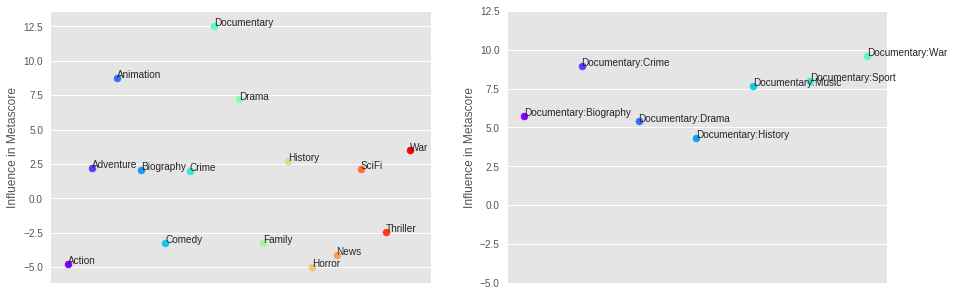

In [9]:
documentary_types = genres.drop('Documentary')

general = smf.ols('metascore ~ ' + ' + '.join(genres), movie_data).fit()
documentaries = smf.ols('metascore ~ Documentary:(' + ' + '.join(documentary_types) + ')', 
                        movie_data).fit()

fig, axes = plt.subplots(ncols=2, figsize=(15,5))
for model, axis in zip([general, documentaries], axes):
    result = pd.concat([model.params, model.bse, model.tvalues, model.pvalues],
                        axis=1, keys=['coef', 'SE', 't', 'p-value'])
    result = result[result['p-value'] < 0.01].drop('Intercept')

    for i, j, color in zip(range(15), result.coef, rainbow_colors):
        axis.scatter(i, j, color=color)
    for i, txt in enumerate(result.index):
        axis.annotate(txt, (range(15)[i], result.coef[i]))
    axis.set_ylabel('Influence in Metascore')
    t = axis.set_xticks([])
    
t = axes[1].set_yticks(np.arange(-5, 12.6, 2.5))

Em uma escala de primeiro nível, é vísivel que os documentários, filmes de animação e de drama estão associados a Metascores maiores, enquanto filmes de ação e de terror se encontram associados a Metascores abaixo do habitual. Apesar disso, como veremos mais abaixo, isso não significa que um filme que pertence aos três gêneros mais bem-avaliados simultaneamente possuirá um Metascore significativamente maior, visto que a associação entre estes gêneros é incomum e que estamos tratando apenas de escalas de primeiro nível.

Já em escalas de segundo nível, podemos ver que os documentários diferem internamente. É possível ver que documentários de guerra são associados a escores mais altos do que os documentários musicais, por exemplo.

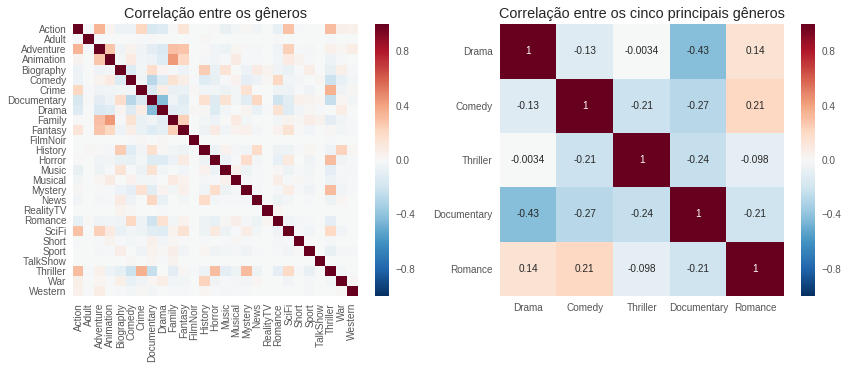

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
sns.heatmap(movie_data[genres].corr(), ax=axes[0])
sns.heatmap(movie_data[fiveGenres].corr(), annot=True, ax=axes[1])
axes[0].set_title('Correlação entre os gêneros');
axes[1].set_title('Correlação entre os cinco principais gêneros')
t = plt.yticks(rotation=0)

Ao mesmo tempo, é possível observar que, no geral, não existe uma grande correlação entre os gêneros dos filmes. Por se tratarem de atributos primordialmente categóricos — mas representados como binários —, uma correlação forte e positiva entre dois elementos (x e y) significa que a presença de x é frequentemente associada à presença de y. Logo, é esperado que não haja uma ampla correlação, visto que se tratam de ligações incomuns de serem estabelecidas. Ainda assim, podemos verificar algumas relações, a exemplo de filmes de ação que são constantemente associados a filmes de aventura, ou filmes de animação que são constantemente associados a filmes voltados à família.

Por outro lado, ao considerar somente os cinco principais gêneros, é possível verificar que estes são majoritariamente independentes, onde a presença de um gênero é constantemente associada a ausência de outro ou onde não há uma correlação propriamente dita. A única ressalva, conforme visto anteriormente no modelo de regressão, fica para os filmes de romance, que se encontram razoavelmente associados aos filmes de drama e de comédia.

# Parte 3 — Escore dos usuários

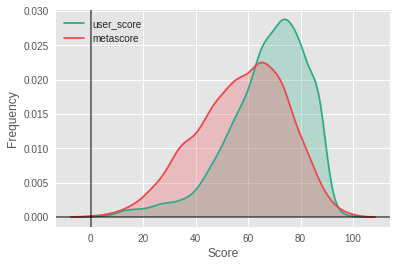

In [11]:
sns.kdeplot(movie_data.user_score.dropna(), color='#29AB87', shade=True)
sns.kdeplot(movie_data.metascore.dropna(), color='#F1444A', shade=True)

plt.axhline(0, color='black', alpha=0.6)
plt.axvline(0, color='black', alpha=0.6)
plt.xlabel('Score')
plt.ylabel('Frequency')

A distribuição de notas nos mostra que os usuários, em um panorama geral, tendem a atribuir escores mais altos e próximos de uma faixa positiva. O Metascore, por sua vez, se apresenta mais distribuído e centrado em torno de avaliações mistas e positivas, além de também possuir maior frequência de escores negativos.

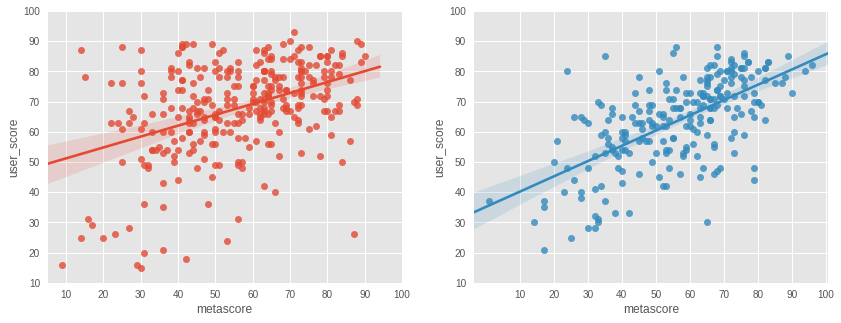

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
past_decade = movie_data[movie_data['release_decade']=='2000s'].sample(400)
now = movie_data[movie_data['release_decade']=='2010s'].sample(400)

sns.regplot('metascore', 'user_score', past_decade, ax=axes[0])
sns.regplot('metascore', 'user_score', now, ax=axes[1])
for axis in axes:
    axis.set_xticks(range(10,101,10))
    axis.set_yticks(range(10,101,10))

Conforme pode ser verificado acima, ao pegarmos uma amostra de 400 elementos, é possível ver que a influência do Metascore sobre o escore global dos usuários aumentou um pouco em relação à última década, apesar de ambas se demonstrarem igualmente pertinentes de que esta influência existe.

# Parte 4 — Outras características

In [13]:
languagesQtd = movie_data.groupby('languages')[['metascore']].count().drop('unknown')
fiveLanguages = languagesQtd.nlargest(5, ['metascore'])
fiveLanguages = [i for i in fiveLanguages.index.values]

In [14]:
getFiveLanguages = lambda i: i[11] in fiveLanguages
topLanguagesDF = movie_data[list(map(getFiveLanguages, movie_data.itertuples()))]
topLanguagesDF.languages.cat.remove_unused_categories(inplace=True)
topLanguagesDF = topLanguagesDF.reset_index(drop=True).dropna()

In [27]:
model = smf.ols(formula='metascore ~ C(languages)', data=topLanguagesDF).fit()

result = pd.concat([model.params, model.bse, model.tvalues, model.pvalues],
                   axis=1, keys=['coef','SE','t','p-value'])
display(result)
display(model.summary())

,coef,SE,t,p-value
Intercept,55.890741,0.331071,168.817936,0.000000e+00
C(languages)[T.French],13.541951,1.755169,7.715467,1.622095e-14
C(languages)[T.German],13.938527,2.765110,5.040858,4.905487e-07
C(languages)[T.Japanese],14.109259,2.798971,5.040874,4.905096e-07
C(languages)[T.Spanish],11.309259,2.641202,4.281861,1.910654e-05


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              metascore   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     30.50
Date:                Sat, 09 Dec 2017   Prob (F-statistic):           6.30e-25
Time:                        16:34:06   Log-Likelihood:                -13064.
No. Observations:                3049   AIC:                         2.614e+04
Df Residuals:                    3044   BIC:                         2.617e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   55.8907      0.331    168.818      0.000      55.242      56.540
C(languages)[T.French]      13.5420      1.755      7.715      0.000      10.101      16.983
C(languages)[T.German]      13.9385      2.765      5.041      0.000       8.517      19.360
C(languages)[T.Japanese]    14.1093      2.799      5.041      0.000       8.621      19.597
C(languages)[T.Spanish]     11.3093      2.641      4.282      0.000       6.131      16.488
==============================================================================
Omnibus:                       57.303   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.681
Skew:                          -0.237   Prob(JB):                     4.43e-11
Kurtosis:                       2.612   Cond. No.                         8.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Apesar de, em um primeiro momento, não termos observado uma correlação entre os gêneros, uma análise mais cuidadosa, selecionando os cinco principais gêneros, nos mostra claramente que há uma relação. A estatística F nos permite concluir, ainda, que estamos melhorando nosso modelo. Podemos também realizar a observação da distribuição por idioma.

In [20]:
meta_content = {}; review_content = {}
for lang in fiveLanguages:
    meta = movie_data.groupby('languages')['metascore']
    review = movie_data.groupby('languages')['review_score']
    meta_content[lang] = meta.get_group(lang).values
    review_content[lang] = review.get_group(lang).values
    
fiveLangsMeta = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in meta_content.items()])).reset_index(drop=True)
fiveLangsReviews = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in review_content.items()])).reset_index(drop=True)

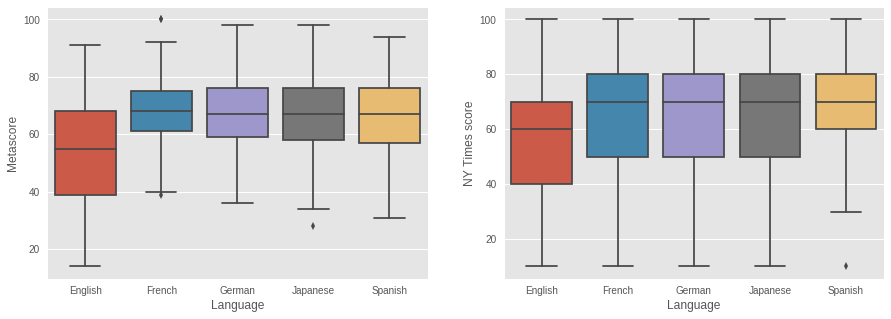

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
sns.boxplot(data=fiveLangsMeta.dropna(), ax=axes[0])
sns.boxplot(data=fiveLangsReviews.dropna(), ax=axes[1])
axes[0].set_ylabel('Metascore'); axes[1].set_ylabel('NY Times score')
for axis in axes: axis.set_xlabel('Language')

É possível ver que a distribuição das avaliações do The New York Times por idioma se apresenta mais heterogênea do que as distribuições dos Metascores. Em ambos os casos, é possível ver que os filmes dos outros idiomas principais se encontram associados a escores maiores do que os filmes em inglês. Em especial, a distribuição do Metascore em filmes franceses se encontra bem homogênea e centrada em torno do polo positivo de resenhas.

In [33]:
directorQtd = movie_data.groupby('director')[['metascore']].count().drop('unknown')
fiveDirectors = directorQtd.nlargest(5, ['metascore'])
fiveDirectors = [i for i in fiveDirectors.index.values]

getFiveDirectors = lambda i: i[10] in fiveDirectors
topDirectorsDF = movie_data[list(map(getFiveDirectors, movie_data.itertuples()))]
topDirectorsDF.director.cat.remove_unused_categories(inplace=True)
topDirectorsDF = topDirectorsDF.reset_index(drop=True).dropna()

model = smf.ols(formula='metascore ~ C(director)', data=topDirectorsDF).fit()

result = pd.concat([model.params, model.bse, model.tvalues, model.pvalues],
                   axis=1, keys=['coef','SE','t','p-value'])
display(result)
display(model.summary())

,coef,SE,t,p-value
Intercept,63.00,4.437449,14.197347,3.092062e-12
C(director)[T.Spike Lee],-4.80,6.275500,-0.764879,4.528539e-01
C(director)[T.Steven Soderbergh],10.00,6.008334,1.664355,1.108931e-01
C(director)[T.Steven Spielberg],13.75,6.656173,2.065752,5.141077e-02
C(director)[T.Woody Allen],1.00,6.008334,0.166435,8.694063e-01


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              metascore   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     2.833
Date:                Sat, 09 Dec 2017   Prob (F-statistic):             0.0504
Time:                        16:59:33   Log-Likelihood:                -93.781
No. Observations:                  26   AIC:                             197.6
Df Residuals:                      21   BIC:                             203.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           63.0000      4.437     14.197      0.000      53.772      72.228
C(director)[T.Spike Lee]            -4.8000      6.276     -0.765      0.453     -17.851       8.251
C(director)[T.Steven Soderbergh]    10.0000      6.008      1.664      0.111      -2.495      22.495
C(director)[T.Steven Spielberg]     13.7500      6.656      2.066      0.051      -0.092      27.592
C(director)[T.Woody Allen]           1.0000      6.008      0.166      0.869     -11.495      13.495
==============================================================================
Omnibus:                        2.825   Durbin-Watson:                   1.782
Prob(Omnibus):                  0.244   Jarque-Bera (JB):                2.137
Skew:                           0.550   Prob(JB):                        0.344
Kurtosis:                       2.127   Cond. No.                         5.96
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Por fim, ao contrário do que esperávamos, ao conduzirmos uma análise mais cuidadosa com os principais diretores, é possível ver que estes não possuem uma influência propriamente dita. Além de o *p-value* apresentado por estes ser alto — o que indica que não podemos rejeitar a hipótese de que estes não são influentes —, o alto valor da F-statistic nos indica ainda que, com a consideração destas variáveis, não estamos melhorando nosso modelo.